In [1]:
import os
import sys
sys.path.append('../')

import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from argparse import Namespace

from dps import darkphoton

### Scheme

In [2]:
with open("../dps/data/dcs/schemes/BLNY.pkl", 'rb') as f:
    blny = pickle.load(f)
    
with open("../dps/data/dcs/schemes/SY.pkl", 'rb') as f:
    sy = pickle.load(f)

In [3]:
masses = list()
for data in sy:
    masses.append(data["M"][0])

In [4]:
def get_deltas(data1, data2, masses, delta_trouble=0.1):
    
    deltas = {"mean": list(), "max": list()}
    troubles = list()
    for i, M in enumerate(masses):
        
        d1 = data1[i]
        d2 = data2[i]
        n = len(d1)
    
        assert len(d1) == len(d2)
    
        delta_mean = 0
        delta_max = 0
        trouble = {"z": list(), "kT": list()}
        for j in range(n): 
            delta = np.abs((d1["css"][j] - d2["css"][j]) / (d1["css"][j] + d2["css"][j]))
            delta_mean += delta
            if delta > delta_max:
                delta_max = delta
            if delta > delta_trouble:
                trouble["z"].append(d1["z"][j])
                trouble["kT"].append(d1["kT"][j])
           
        deltas["mean"].append(delta_mean / n)
        deltas["max"].append(delta_max)
        troubles.append(trouble)
                      
    return deltas, troubles

In [5]:
deltas, troubles = get_deltas(blny, sy, masses)

<IPython.core.display.Javascript object>


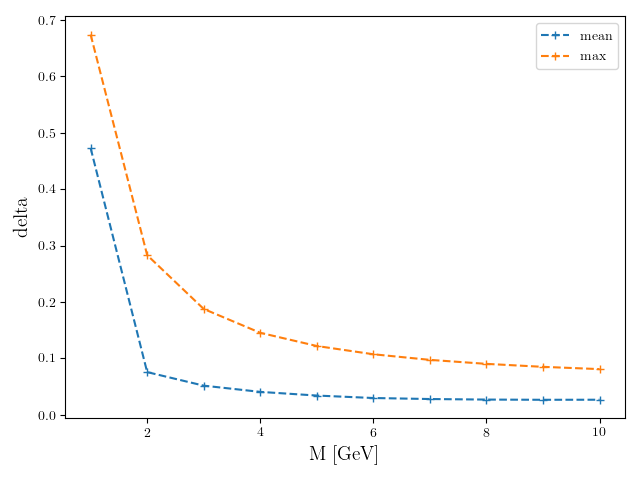

In [6]:
%matplotlib notebook

fig, ax = plt.subplots()

ax.plot(masses, deltas["mean"], color="C0", marker="+", Linestyle="--", label="mean")
ax.plot(masses, deltas["max"], color="C1", marker="+", Linestyle="--", label="max")
    
ax.set_xlabel("M [GeV]", fontsize=14)
ax.set_ylabel("delta", fontsize=14)

ax.set(xscale='linear', yscale='linear')

plt.legend()
plt.tight_layout()
plt.show()

### pdf + scale

In [7]:
from dps.data import sort

In [8]:
uncertainty = sort.sort("dcs/uncertainty")

In [9]:
def get_deltas(data, kind, method, dsmin=1e-9, dsmax=1):
    
    zs = list()
    kTs = list()
    deltas = list()    
    for (x1, x2), x, z, kT in zip(data[method][kind], data[method]["central"], data["z"], data["kT"]):   
        if dsmax > x > dsmin and np.sign(x1 * x2) == 1:
            deltas.append(np.abs((x1 - x2) / (x1 + x2)))
            zs.append(z)
            kTs.append(kT)          
    
    return np.array(deltas), np.array(zs), np.array(kTs)

def find_troubles(deltas, delta_max=1):

    index = list()
    for i, delta in enumerate(deltas):
        if delta > delta_max:
            index.append(i)
            
    return index

In [10]:
res = {"pdf": {"nlo": list(), "css": list(), "div": list()}, "scale": {"nlo": list(), "div": list()}}

for key1 in res.keys():
    for key2 in res[key1].keys():
        x = list()
        for data in uncertainty[1]:
            deltas, zs, kTs = get_deltas(data, key1, key2, dsmin=1e-9)
            x.append(deltas.mean())
        res[key1][key2] = x
        
masses2 = [x.M for x in uncertainty[0]]

<IPython.core.display.Javascript object>


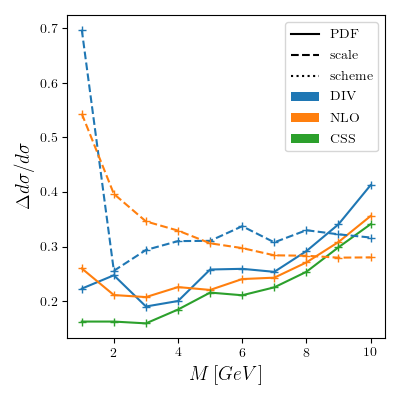

In [13]:
%matplotlib notebook

labels = [Line2D([0], [0], color="k", Linestyle="-", label=r"PDF"),
          Line2D([0], [0], color="k", Linestyle="--", label=r"scale"),
          Line2D([0], [0], color="k", Linestyle="dotted", label=r"scheme"),
          Patch(facecolor="C0", label=r"DIV"),
          Patch(facecolor="C1", label=r"NLO"),
          Patch(facecolor="C2", label=r"CSS")]

fig, ax = plt.subplots(figsize=(4, 4))

for i, key in enumerate(["div", "nlo", "css"]):   
    ax.plot(masses2, res["pdf"][key], color="C{}".format(i), marker="+", Linestyle="-")
    
for i, key in enumerate(["div", "nlo"]):
    ax.plot(masses2, res["scale"][key], color="C{}".format(i), marker="+", Linestyle="--")
    
# ax.plot(masses, deltas["mean"], marker='+', Linestyle='dotted', color='k')

ax.set_xlabel(r"$M\: [GeV]$", fontsize=14)
ax.set_ylabel(r"$\Delta d\sigma / d\sigma$", fontsize=14)

ax.set(xscale='linear', yscale='linear')

plt.legend(handles=labels)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


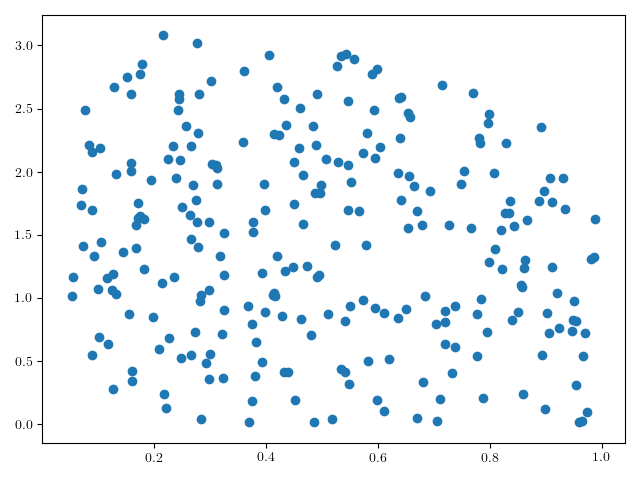

In [121]:
%matplotlib notebook

fig, ax = plt.subplots()
ax.scatter(zs, kTs)
plt.tight_layout()

In [16]:
deltas = list()
for i, M in enumerate(masses):
    deltas.append(get_deltas(datas[i]))

<IPython.core.display.Javascript object>


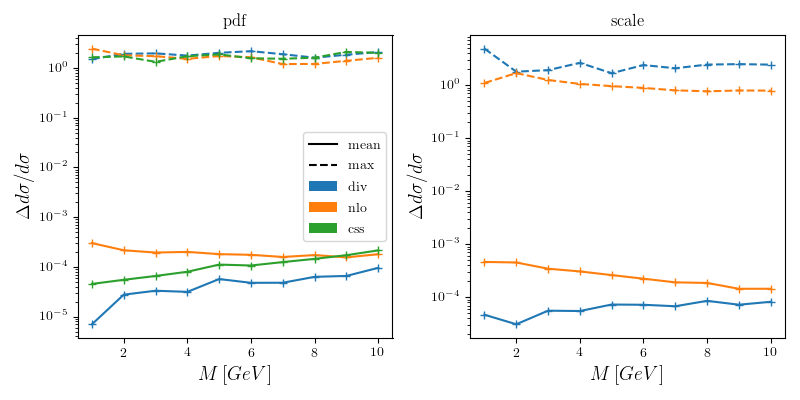

In [17]:
%matplotlib notebook

labels = [Line2D([0], [0], color="k", Linestyle="-", label="mean"),
          Line2D([0], [0], color="k", Linestyle="--", label="max"),
          Patch(facecolor="C0", label="div"),
          Patch(facecolor="C1", label="nlo"),
          Patch(facecolor="C2", label="css")]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

for i, key in enumerate(["div", "nlo", "css"]):
    
    delta_mean = np.array([delta["pdf"][key]["mean"] for delta in deltas])
    delta_max = np.array([delta["pdf"][key]["max"] for delta in deltas])
    
    ax[0].plot(masses, delta_mean, color="C{}".format(i), marker="+", Linestyle="-")
    ax[0].plot(masses, delta_max, color="C{}".format(i), marker="+", Linestyle="--")
    
for i, key in enumerate(["div", "nlo"]):
    
    delta_mean = np.array([delta["scale"][key]["mean"] for delta in deltas])
    delta_max = np.array([delta["scale"][key]["max"] for delta in deltas])
    
    ax[1].plot(masses, delta_mean, color="C{}".format(i), marker="+", Linestyle="-")
    ax[1].plot(masses, delta_max, color="C{}".format(i), marker="+", Linestyle="--")
        
       
ax[0].title.set_text(r"pdf")
ax[1].title.set_text(r"scale")
    
ax[0].set_xlabel(r"$M\: [GeV]$", fontsize=14)
ax[0].set_ylabel(r"$\Delta d\sigma / d\sigma$", fontsize=14)

ax[1].set_xlabel(r"$M\: [GeV]$", fontsize=14)
ax[1].set_ylabel(r"$\Delta d\sigma / d\sigma$", fontsize=14)

ax[0].set(xscale='linear', yscale='log')
ax[1].set(xscale='linear', yscale='log')

ax[0].legend(handles=labels)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


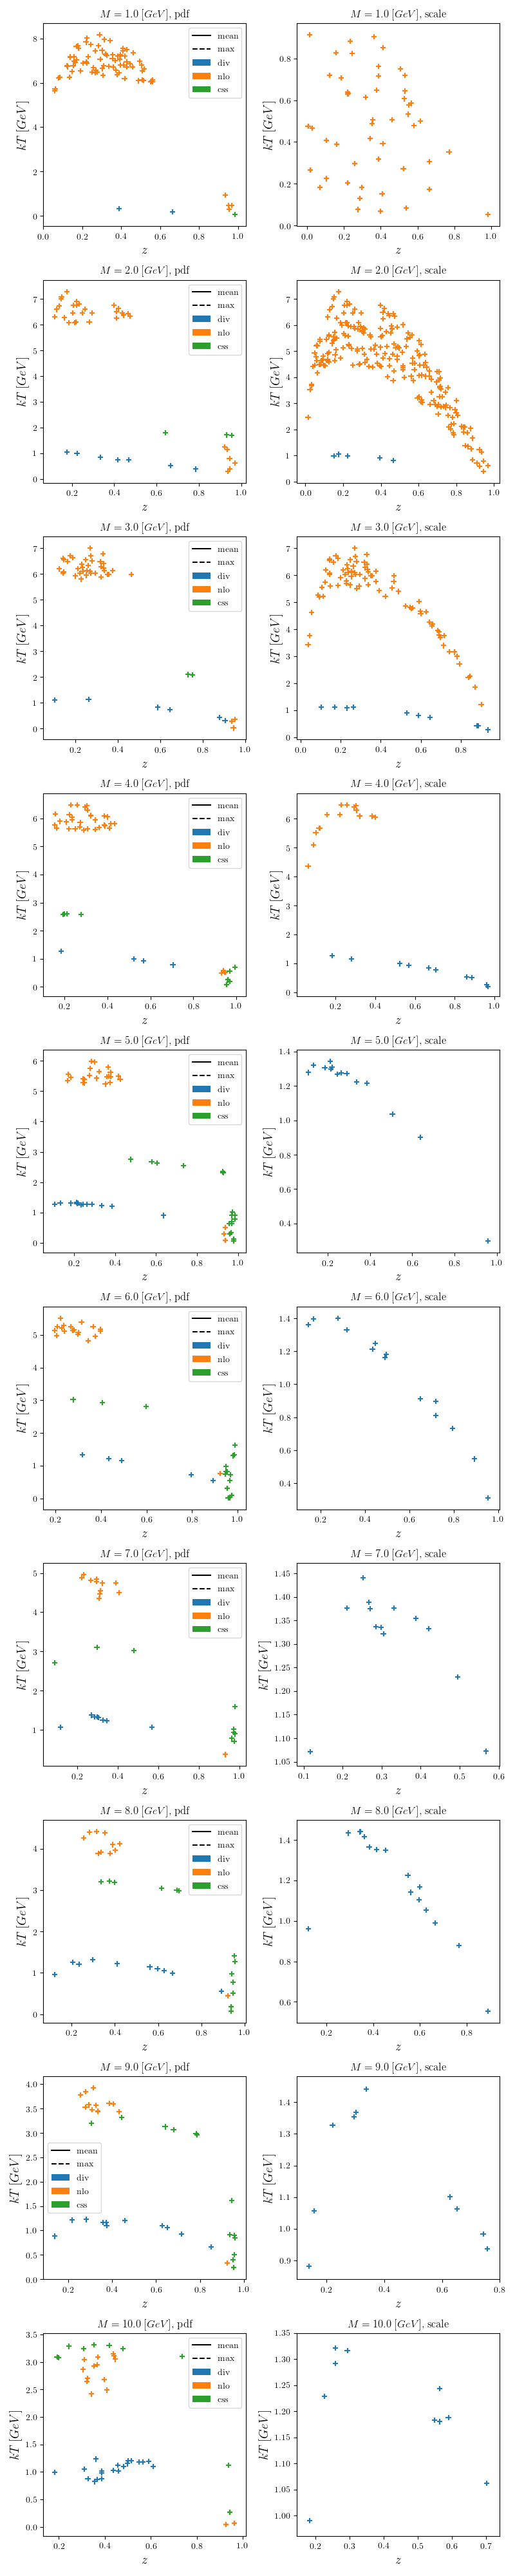

In [51]:
%matplotlib notebook

labels = [Line2D([0], [0], color="k", Linestyle="-", label="mean"),
          Line2D([0], [0], color="k", Linestyle="--", label="max"),
          Patch(facecolor="C0", label="div"),
          Patch(facecolor="C1", label="nlo"),
          Patch(facecolor="C2", label="css")]

fig, ax = plt.subplots(10, 2, figsize=(8, 10*4))

for i, M in enumerate(masses):

    for j, key in enumerate(["div", "nlo", "css"]):

        z = deltas[i]["pdf"][key]["troubles"]["z"]
        kT = deltas[i]["pdf"][key]["troubles"]["kT"]

        ax[i, 0].scatter(z, kT, color="C{}".format(j), marker="+", Linestyle="-")
        ax[i, 0].scatter(z, kT, color="C{}".format(j), marker="+", Linestyle="--")

    for j, key in enumerate(["div", "nlo"]):

        z = deltas[i]["scale"][key]["troubles"]["z"]
        kT = deltas[i]["scale"][key]["troubles"]["kT"]

        ax[i, 1].scatter(z, kT, color="C{}".format(j), marker="+", Linestyle="-")
        ax[i, 1].scatter(z, kT, color="C{}".format(j), marker="+", Linestyle="--")

       
    ax[i, 0].title.set_text(r"$M={}\:[GeV]$, pdf".format(M))
    ax[i, 1].title.set_text(r"$M={}\:[GeV]$, scale".format(M))

    ax[i, 0].set_xlabel(r"$z$", fontsize=14)
    ax[i, 0].set_ylabel(r"$kT \: [GeV]$", fontsize=14)
    
    ax[i, 1].set_xlabel(r"$z$", fontsize=14)
    ax[i, 1].set_ylabel(r"$kT \: [GeV]$", fontsize=14)

    ax[i, 0].legend(handles=labels)

plt.tight_layout()
plt.show()